In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, or_, and_

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
msmnt = Base.classes.measurement
stats = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [13]:
first_row = session.query(msmnt).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25d82c7dac8>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [14]:
first_row = session.query(stats).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25d82cbc0f0>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

## Precipitation Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
maxdatefind = session.query(func.max(msmnt.date))
maxdate = maxdatefind[0][0]
print(maxdate)
mindate = f'{int(maxdate[0:4])-1}{maxdate[4:10]}'
print(mindate)

2017-08-23
2016-08-23


In [16]:
# Perform a query to retrieve the data and precipitation scores
datesprcps = session.query(msmnt.date, msmnt.prcp).filter(msmnt.date >= mindate)
# Save the query results as a Pandas DataFrame and set the index to the date column
dateprcp_df = pd.DataFrame(datesprcps)
# Sort the dataframe by date
dateprcp_df = dateprcp_df.sort_values("date")
dateprcp_df = dateprcp_df.set_index("date")
dateprcp_df = dateprcp_df.rename(columns={"prcp":"precipitation"})

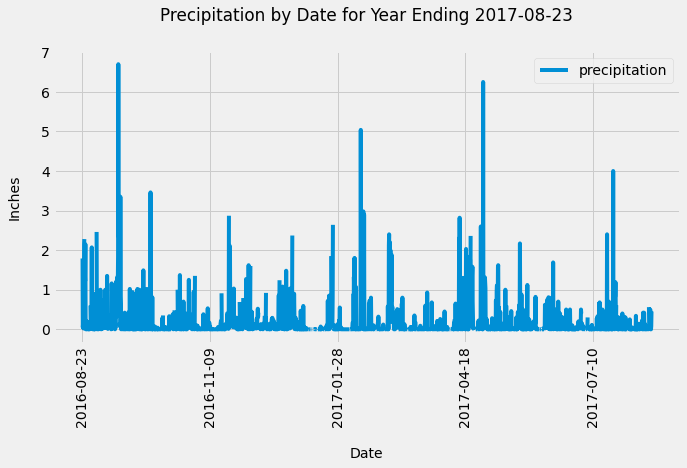

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
dateprcp_df.plot(figsize=(10,5))
plt.legend(loc='upper right')
plt.xticks(rotation="vertical",size='medium')
plt.xlabel("Date",labelpad=20, size='medium')
plt.ylabel("Inches",labelpad=20,size='medium')
plt.title(f"Precipitation by Date for Year Ending {maxdate}",pad=30,size='large')
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
dateprcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [19]:
# Design a query to show how many stations are available in this dataset?
stationcount = session.query(msmnt).group_by(msmnt.station).count()
print(f'Total number of stations in the dataset: {stationcount}')

Total number of stations in the dataset: 9


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
statsobs = session.query(msmnt.station, func.count(msmnt.station)).group_by(msmnt.station).\
    order_by(func.count(msmnt.station).desc())
print("Stations in Descending Order of Observations")
for row in statsobs:
    print(row)

Stations in Descending Order of Observations
('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [21]:
maxstatfind = session.query(msmnt.station).group_by(msmnt.station).order_by(func.count(msmnt.station).desc()).first()
maxstation = maxstatfind[0]
print(f"Station {maxstation} has the highest number of observations.")

Station USC00519281 has the highest number of observations.


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
mintempfind = session.query(msmnt.tobs).filter(and_(msmnt.date >= mindate, msmnt.station == maxstation)).\
                                               order_by(msmnt.tobs).first()
maxtempfind = session.query(msmnt.tobs).filter(and_(msmnt.date >= mindate, msmnt.station == maxstation)).\
                                               order_by(msmnt.tobs.desc()).first()
avgtempfind = session.query(func.avg(msmnt.tobs)).filter(and_(msmnt.date > mindate, msmnt.station == maxstation))
print(f'Stats for station {maxstation} for period {mindate} to {maxdate}:')
print(f'Lowest temperature recorded: {mintempfind[0]}')
print(f'Highest temperature recorded: {maxtempfind[0]}')
print(f'Average temperature recorded: {round(avgtempfind[0][0],1)}')

Stats for station USC00519281 for period 2016-08-23 to 2017-08-23:
Lowest temperature recorded: 59.0
Highest temperature recorded: 83.0
Average temperature recorded: 73.1


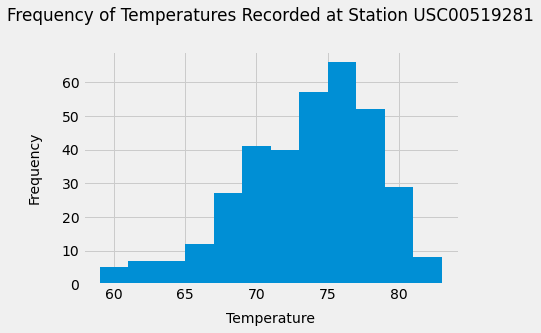

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
maxstation_temps = []
maxstation_find = engine.execute(f"SELECT tobs FROM measurement WHERE station = '{maxstation}' AND date > '{mindate}'")
for row in maxstation_find:
    maxstation_temps.append(row[0])
plt.hist(maxstation_temps, bins=12)
plt.title(f'Frequency of Temperatures Recorded at Station {maxstation}',pad=30,size='large')
plt.xlabel('Temperature',labelpad=10,size='medium')
plt.ylabel('Frequency',labelpad=20,size='medium')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [ ]:
# alldates = engine.execute("SELECT date FROM measurement")
# maxdate = max(alldates)[0]
# print(maxdate)
# mindate = f'{int(maxdate[0:4])-1}{maxdate[4:10]}'
# print(mindate)

### First full try

In [ ]:
# maxdate = '1900-01-01'
# for row in session.query(msmnt.date).all():
#     if row[0] > maxdate:
#         maxdate = row[0]
# mindate = f'{int(maxdate[0:4])-1}{maxdate[4:10]}'
# print(mindate)

In [ ]:
# maxdatefind = engine.execute("SELECT MAX(date) FROM measurement")
# for date in maxdatefind:
#     maxdate = date[0]
# print(maxdate)
# mindate = f'{int(maxdate[0:4])-1}{maxdate[4:10]}'
# print(mindate) 

In [ ]:
# dates3 = []
# prcps3 = []
# yeardata = engine.execute(f"SELECT date, prcp FROM measurement WHERE date >= '{mindate}'")
# for row in yeardata:
#     dates3.append(row[0])
#     prcps3.append(row[1])

In [ ]:
# date3prcp = pd.DataFrame({'Date':dates3,'Precipitation':prcps3})
# date3prcp = date3prcp.sort_values(['Date'])
# date3prcp = date3prcp.set_index(['Date'])

In [ ]:
# dates2 = []
# prcps2 = []

# results = session.query(msmnt).filter(msmnt.date >= mindate)
# for result in results:
#     dates2.append(result.date)
#     prcps2.append(result.prcp)

In [ ]:
# date2prcp = pd.DataFrame({'Date':dates2,'Precipitation':prcps2})
# date2prcp = date2prcp.sort_values(['Date'])
# date2prcp = date2prcp.set_index(['Date'])

In [ ]:
# date2prcp.plot(figsize=(10,5))
# plt.legend(loc='upper right')
# plt.xticks(rotation="vertical",size='medium')
# plt.xlabel("Date",labelpad=20, size='medium')
# plt.ylabel("Inches",labelpad=20,size='medium')
# plt.title("Precipitation in Honolulu for the Year Ending Aug. 23, 2017",pad=30,size='large')
# plt.show()

In [ ]:
# date2prcp.describe()

In [ ]:
# # What are the most active stations? (i.e. what stations have the most rows)?
# # List the stations and the counts in descending order.
# stations = []
# for row in session.query(msmnt):
#     if row.station not in stations:
#         stations.append(row.station)

In [ ]:
# obscounts = []
# for station in stations:
#     obscount = session.query(msmnt).filter(msmnt.station == station)
#     obscounts.append(obscount.count())

In [ ]:
# statsobs_df = pd.DataFrame({'StationID':stations,'Observations':obscounts})
# statsobs_df = statsobs_df.sort_values(['Observations'],ascending=False)
# statsobs_df = statsobs_df.set_index(['StationID'])
# statsobs_df

In [ ]:
# homer = session.query(msmnt.station, func.count(msmnt.station)).group_by(msmnt.station).\
#     order_by(func.count(msmnt.station).desc()).first()
# print(homer[0])

In [ ]:
# maxstation = statsobs_df.loc[statsobs_df["Observations"] == max(statsobs_df["Observations"])].index[0]
# print(f'The station {maxstation} has the highest number of observations.')

In [ ]:
# # What are the most active stations? (i.e. what stations have the most rows)?
# # List the stations and the counts in descending order.
# stationdata = engine.execute("SELECT station, COUNT(station) FROM measurement GROUP BY station ORDER BY count(station) DESC;")
# stations3 = []
# obscounts3 = []
# for row in stationdata:
#     print(row)
#     stations3.append(row[0])
#     obscounts3.append(row[1])

In [ ]:
# # Using the station id from the previous query, calculate the lowest temperature recorded, 
# # highest temperature recorded, and average temperature of the most active station?
# maxstation_temps = []
# for row in session.query(msmnt):
#     if row.date >= mindate:
#         if row.station == maxstation:
#             maxstation_temps.append(row.tobs)
# print(f'Stats for station {maxstation} for period {mindate} to {maxdate}:')
# print(f'Lowest temperature recorded: {min(maxstation_temps)}')
# print(f'Highest temperature recorded: {max(maxstation_temps)}')
# print(f'Average recorded temperature: {round(np.mean(maxstation_temps),2)}')

In [ ]:
# # Using the station id from the previous query, calculate the lowest temperature recorded, 
# # highest temperature recorded, and average temperature of the most active station?
# maxstation_temps = []
# for row in session.query(msmnt):
#     if row.station == maxstation:
#         maxstation_temps.append(row.tobs)
# print(f'Stats for station {maxstation} for period {mindate} to {maxdate}:')
# print(f'Lowest temperature recorded: {min(maxstation_temps)}')
# print(f'Highest temperature recorded: {max(maxstation_temps)}')
# print(f'Average recorded temperature: {round(np.mean(maxstation_temps),2)}')

### Using python and pandas to query

In [ ]:
# for row in session.query(msmnt.date, msmnt.prcp).all():
#     if row[0] >= '2016-08-23':
#         print(row)

In [ ]:
# dates = []
# prcps = []
# for row in session.query(msmnt.date, msmnt.prcp).all():
#     if row[0] >= '2016-08-23':
#         dates.append(row[0])
#         prcps.append(row[1])

In [ ]:
# date_prcp = pd.DataFrame({'Date':dates,'Precipitation':prcps})
# # date_prcp['Precipitation'] = date_prcp['Precipitation'].fillna(0)
# date_prcp

In [ ]:
# date_prcp.describe()

### Me trying this with the method from the previous assignment

In [ ]:
# connection = engine.connect()

In [ ]:
# measurements_df = pd.read_sql('select * from measurement',connection)
# measurements_df

In [ ]:
# measurements_df["date"].max()

In [ ]:
# measurements_df["prcp"].max()

In [ ]:
# station_df = pd.read_sql('select * from station',connection)
# station_df